In [1]:
import torch, pickle, argparse, os, warnings, copy, time, mlflow
import numpy as np, pytorch_lightning as pl, matplotlib.pyplot as plt, eagerpy as ep
from models import ConvNet, S2ConvNet
from data_loader import load_test_data, load_train_data
from foolbox import PyTorchModel
from foolbox.attacks import LinfProjectedGradientDescentAttack
from foolbox.attacks.base import Repeated
from tqdm.notebook import tqdm
from attack_helper import run_batched_attack_cpu, batched_accuracy, batched_predictions, batched_predictions_eps, batched_logits_eps, save_pickle
from mlflow.tracking.artifact_utils import get_artifact_uri
import matplotlib.pyplot as plt

In [2]:
run_name = 1668559990 # S2CNN

total = 1
bs = 1

epsilons = [0, 0.1, 0.25, 0.5, 1, 3, 5, 7.5, 10]
rel_stepsize = 0.01/0.3
steps = 70
random_start = False
n_repeat = 1

In [3]:
test_data_path_orig = "s2_mnist_cs1.gz"
test_data_path_mixed = "s2_mnist_test_sphere_center.gz"
test_data_orig = load_test_data(test_data_path_orig)
test_data_mixed = load_train_data(test_data_path_mixed)

flipped = torch.flip(test_data_mixed[:][0], (3,))
test_data = torch.utils.data.TensorDataset(flipped, test_data_mixed[:][1])

# trainer = pl.Trainer(gpus=1, logger=None)
trainer = pl.Trainer(gpus=0, logger=None)

GPU available: True, used: False
TPU available: False, using: 0 TPU cores


In [4]:
tracking_uri = 'sqlite:///mlruns/database.db'
mlflow.set_tracking_uri(tracking_uri)
df=mlflow.search_runs(experiment_names=['model_training'])
run_id=df[df['tags.mlflow.runName']==str(run_name)]['run_id'].values[0]
artifact_path = get_artifact_uri(run_id=run_id, tracking_uri=tracking_uri)
dirs=os.listdir(artifact_path)

for s in dirs:
    if s.find('.ckpt') >= 0:
        checkpoint = s
        break

checkpoint_path = os.path.join(artifact_path, checkpoint)

best_model = torch.load(checkpoint_path)
hparams = argparse.Namespace(**best_model['hyper_parameters'])

In [5]:
if df[df['tags.mlflow.runName']==str(run_name)]['tags.model'].values[0] == 'ConvNet':
    model = ConvNet(hparams, None, None).eval()
elif df[df['tags.mlflow.runName']==str(run_name)]['tags.model'].values[0] == 'S2ConvNet':
    model = S2ConvNet(hparams, None, None).eval()
else:
    raise NotImplementedError(f"Model has to be 'ConvNet', 'CConvNet' or 'S2ConvNet'. Got {df[df['tags.mlflow.runName']==str(args.run_name)]['tags.model'].values[0]}.")
    
model.load_state_dict(best_model['state_dict'])

<All keys matched successfully>

In [10]:
model=model.cuda()

In [11]:
import lie_learn.spaces.S2 as S2
from torchvision import datasets


NORTHPOLE_EPSILON = 1e-3


def rand_rotation_matrix(deflection=1.0, randnums=None):
    """
    Creates a random rotation matrix.
    
    deflection: the magnitude of the rotation. For 0, no rotation; for 1, competely random
    rotation. Small deflection => small perturbation.
    randnums: 3 random numbers in the range [0, 1]. If `None`, they will be auto-generated.
    
    # http://blog.lostinmyterminal.com/python/2015/05/12/random-rotation-matrix.html
    """

    if randnums is None:
        randnums = np.random.uniform(size=(3,))

    theta, phi, z = randnums

    theta = theta * 2.0*deflection*np.pi  # Rotation about the pole (Z).
    phi = phi * 2.0*np.pi  # For direction of pole deflection.
    z = z * 2.0*deflection  # For magnitude of pole deflection.

    # Compute a vector V used for distributing points over the sphere
    # via the reflection I - V Transpose(V).  This formulation of V
    # will guarantee that if x[1] and x[2] are uniformly distributed,
    # the reflected points will be uniform on the sphere.  Note that V
    # has length sqrt(2) to eliminate the 2 in the Householder matrix.

    r = np.sqrt(z)
    V = (
        np.sin(phi) * r,
        np.cos(phi) * r,
        np.sqrt(2.0 - z)
    )

    st = np.sin(theta)
    ct = np.cos(theta)

    R = np.array(((ct, st, 0), (-st, ct, 0), (0, 0, 1)))

    # Construct the rotation matrix  ( V Transpose(V) - I ) R.

    M = (np.outer(V, V) - np.eye(3)).dot(R)
    return M


def rotate_grid(rot, grid):
    x, y, z = grid
    xyz = np.array((x, y, z))
    x_r, y_r, z_r = np.einsum('ij,jab->iab', rot, xyz)
    return x_r, y_r, z_r


def get_projection_grid(b, grid_type="Driscoll-Healy"):
    ''' returns the spherical grid in euclidean
    coordinates, where the sphere's center is moved
    to (0, 0, 1)'''
    theta, phi = S2.meshgrid(b=b, grid_type=grid_type)
    x_ = np.sin(theta) * np.cos(phi)
    y_ = np.sin(theta) * np.sin(phi)
    z_ = np.cos(theta)
    return x_, y_, z_


def project_sphere_on_xy_plane(grid, projection_origin):
    ''' returns xy coordinates on the plane
    obtained from projecting each point of
    the spherical grid along the ray from
    the projection origin through the sphere '''

    sx, sy, sz = projection_origin
    x, y, z = grid
    z = z.copy() + 1

    t = -z / (z - sz)
    qx = t * (x - sx) + x
    qy = t * (y - sy) + y

    xmin = 1/2 * (-1 - sx) + -1
    ymin = 1/2 * (-1 - sy) + -1

    # ensure that plane projection
    # ends up on southern hemisphere
    rx = (qx - xmin) / (2 * np.abs(xmin))
    ry = (qy - ymin) / (2 * np.abs(ymin))

    return rx, ry


def sample_within_bounds(signal, x, y, bounds):
    ''' '''
    xmin, xmax, ymin, ymax = bounds

    idxs = (xmin <= x) & (x < xmax) & (ymin <= y) & (y < ymax)

    if len(signal.shape) > 2:
        sample = np.zeros((signal.shape[0], x.shape[0], x.shape[1]))
        sample[:, idxs] = signal[:, x[idxs], y[idxs]]
    else:
        sample = np.zeros((x.shape[0], x.shape[1]))
        sample[idxs] = signal[x[idxs], y[idxs]]
    return sample


def sample_bilinear(signal, rx, ry):
    ''' '''

    signal_dim_x = signal.shape[1]
    signal_dim_y = signal.shape[2]

    rx *= signal_dim_x
    ry *= signal_dim_y

    # discretize sample position
    ix = rx.astype(int)
    iy = ry.astype(int)

    # obtain four sample coordinates
    ix0 = ix - 1
    iy0 = iy - 1
    ix1 = ix + 1
    iy1 = iy + 1

    bounds = (0, signal_dim_x, 0, signal_dim_y)

    # sample signal at each four positions
    signal_00 = sample_within_bounds(signal, ix0, iy0, bounds)
    signal_10 = sample_within_bounds(signal, ix1, iy0, bounds)
    signal_01 = sample_within_bounds(signal, ix0, iy1, bounds)
    signal_11 = sample_within_bounds(signal, ix1, iy1, bounds)

    # linear interpolation in x-direction
    fx1 = (ix1-rx) * signal_00 + (rx-ix0) * signal_10
    fx2 = (ix1-rx) * signal_01 + (rx-ix0) * signal_11

    # linear interpolation in y-direction
    return (iy1 - ry) * fx1 + (ry - iy0) * fx2


def project_2d_on_sphere(signal, grid, projection_origin=None):
    ''' '''
    if projection_origin is None:
        projection_origin = (0, 0, 2 + NORTHPOLE_EPSILON)

    rx, ry = project_sphere_on_xy_plane(grid, projection_origin)
    sample = sample_bilinear(signal, rx, ry)

    # ensure that only south hemisphere gets projected
    sample *= (grid[2] <= 1).astype(np.float64)

    # rescale signal to [0,1]
    sample_min = sample.min(axis=(1, 2)).reshape(-1, 1, 1)
    sample_max = sample.max(axis=(1, 2)).reshape(-1, 1, 1)

    sample = (sample - sample_min) / (sample_max - sample_min)
    sample *= 255
    sample = sample.astype(np.uint8)

    return sample

In [12]:
def rotation_matrix(theta, phi, z):
    theta = theta * 2.0*np.pi  # Rotation about the pole (Z).
    phi = phi * 2.0*np.pi  # For direction of pole deflection.
    z = z * 2.0  # For magnitude of pole deflection.

    # Compute a vector V used for distributing points over the sphere
    # via the reflection I - V Transpose(V).  This formulation of V
    # will guarantee that if x[1] and x[2] are uniformly distributed,
    # the reflected points will be uniform on the sphere.  Note that V
    # has length sqrt(2) to eliminate the 2 in the Householder matrix.

    r = np.sqrt(z)
    V = (
        np.sin(phi) * r,
        np.cos(phi) * r,
        np.sqrt(2.0 - z)
    )

    st = np.sin(theta)
    ct = np.cos(theta)

    R = np.array(((ct, st, 0), (-st, ct, 0), (0, 0, 1)))

    # Construct the rotation matrix  ( V Transpose(V) - I ) R.

    M = (np.outer(V, V) - np.eye(3)).dot(R)
    return M

In [13]:
mnist_data_folder = "MNIST_data"
bandwidth = 30
chunk_size = 1

In [14]:
testset = datasets.MNIST(root=mnist_data_folder, train=False, download=True)
mnist_test = {}
mnist_test['images'] = testset.data.numpy()
mnist_test['labels'] = testset.targets.numpy()

In [15]:
grid = get_projection_grid(b=bandwidth)

rot = rotation_matrix(theta=0.5, phi=0.75, z=0.5)
wanted = np.array([[0, 0, -1], [0, -1, 0], [1, 0, 0]])
print(rot, '\n', wanted)

[[-2.24963967e-32 -1.83697020e-16 -1.00000000e+00]
 [-6.12323400e-17  1.00000000e+00 -1.83697020e-16]
 [ 1.00000000e+00  6.12323400e-17  0.00000000e+00]] 
 [[ 0  0 -1]
 [ 0 -1  0]
 [ 1  0  0]]


In [17]:
n_images = 60
x = {}
x['images'] = mnist_test['images'][0].reshape(1,28,28).astype(np.float64)
x['labels'] = mnist_test['labels'][0]

image = x['images']
projections = np.ndarray((n_images, 2 * bandwidth, 2 * bandwidth), dtype=np.uint8)
for i in range(n_images):
    grid = get_projection_grid(b=bandwidth)
    rot = rotation_matrix(theta=i/60, phi=0.75, z=0.5)
    rotated_grid = rotate_grid(rot, grid)
    projections[i] = project_2d_on_sphere(image, rotated_grid)

y = torch.from_numpy(projections.astype(np.float32)).unsqueeze(1)

In [18]:
y.size()

torch.Size([60, 1, 60, 60])

In [36]:
test_data[0]

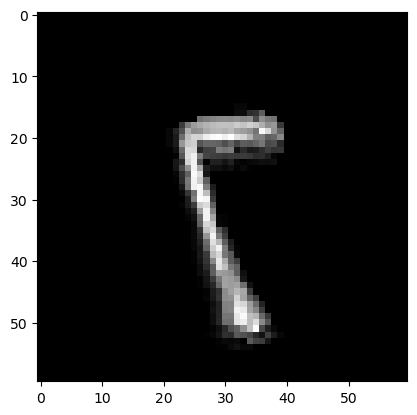

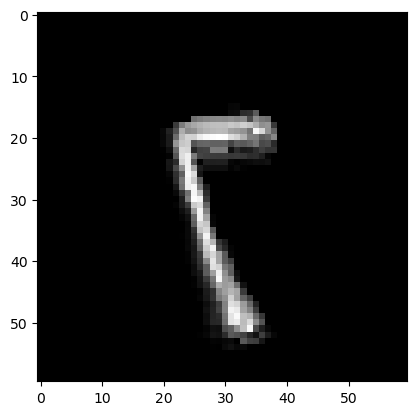

In [37]:
plt.imshow(y[30,0], cmap='gray')
plt.show()
plt.imshow(test_data[0][0][0], cmap='gray')
plt.show()

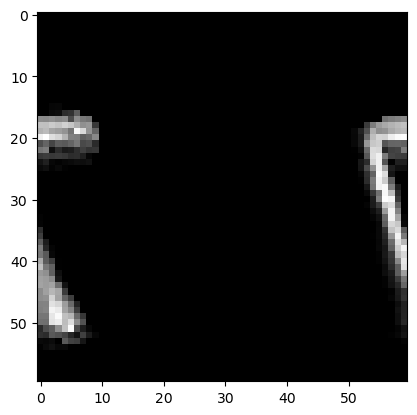

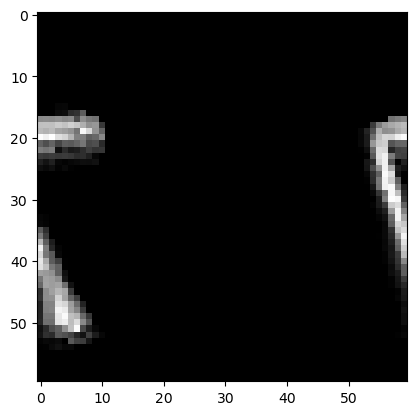

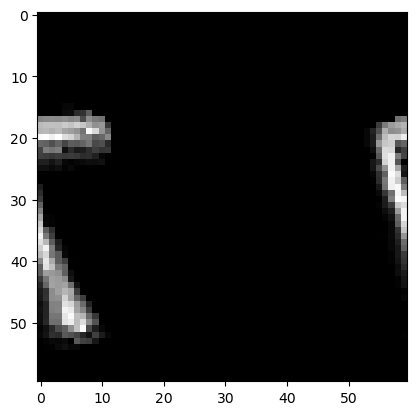

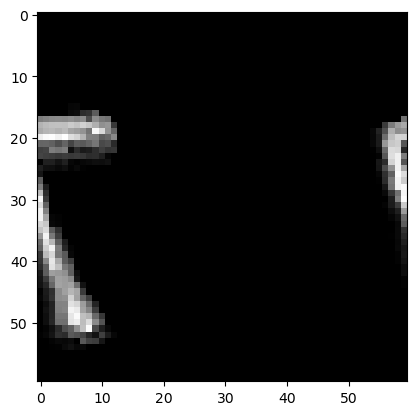

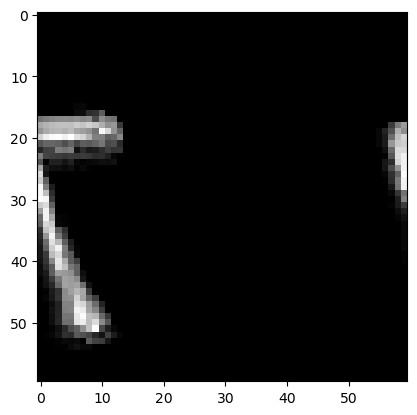

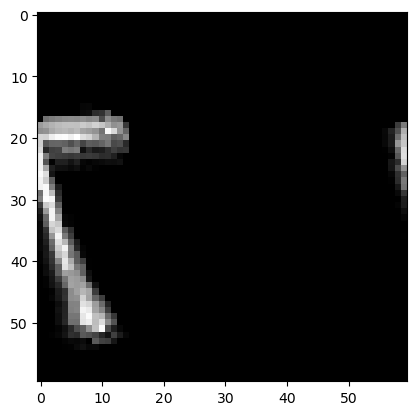

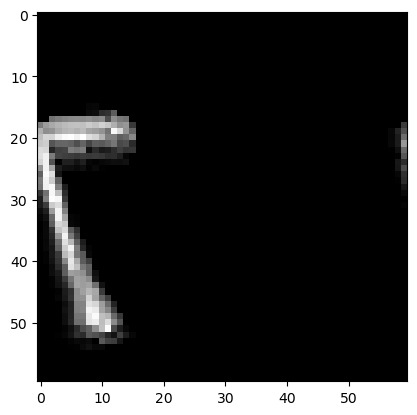

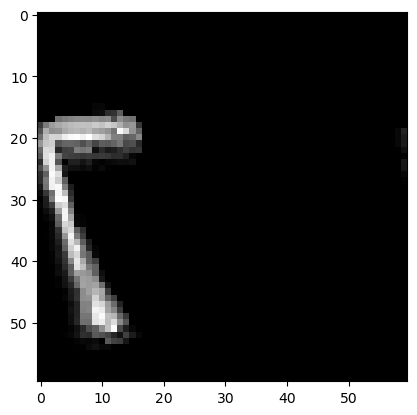

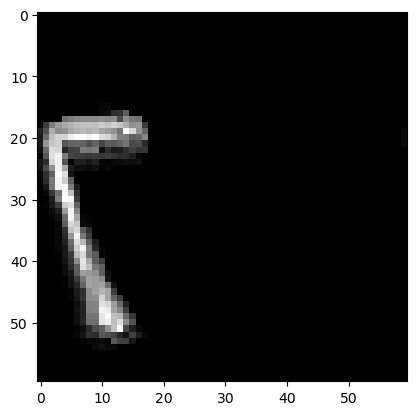

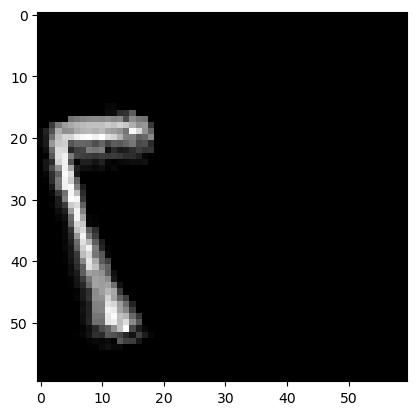

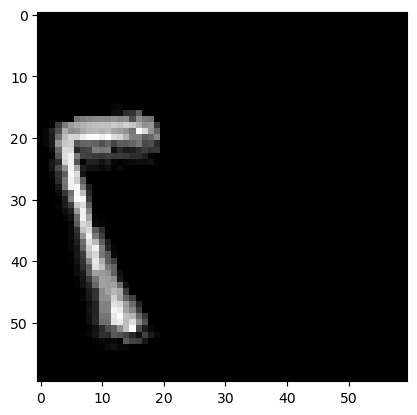

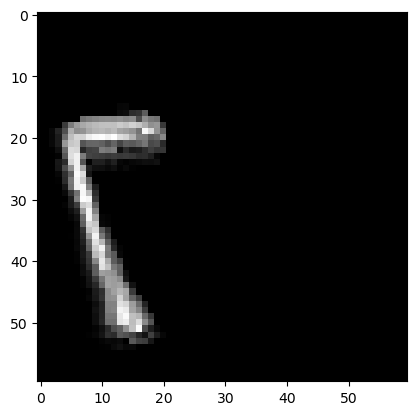

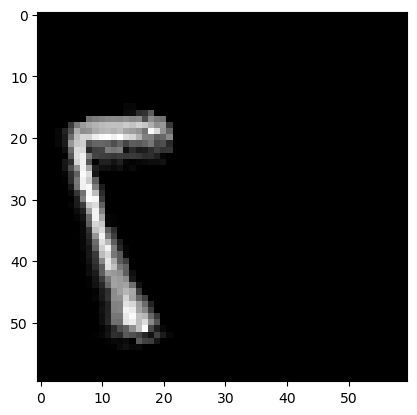

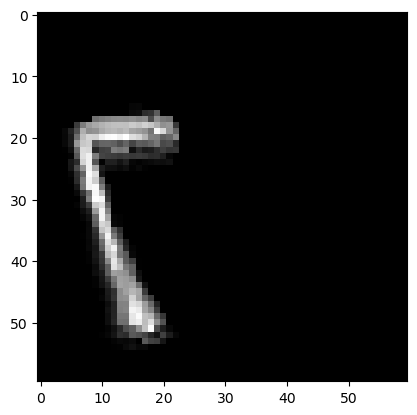

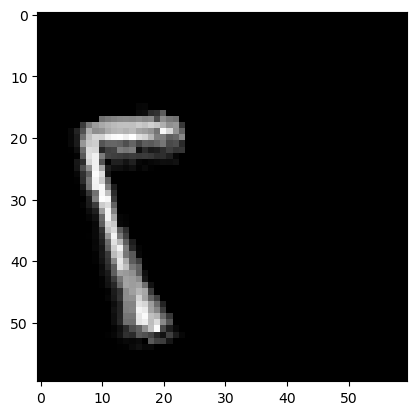

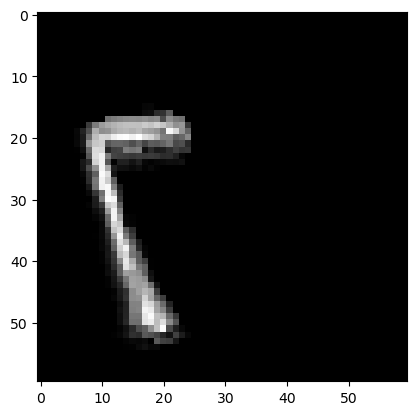

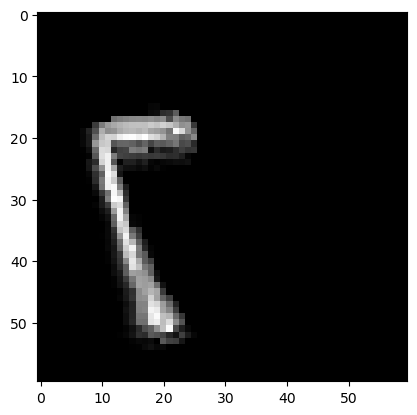

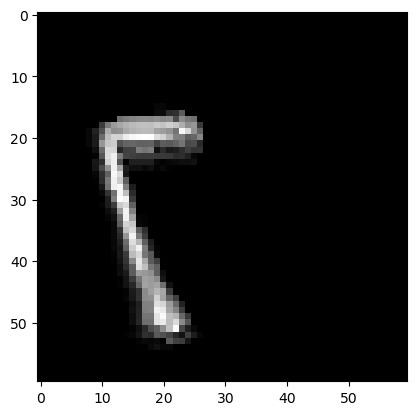

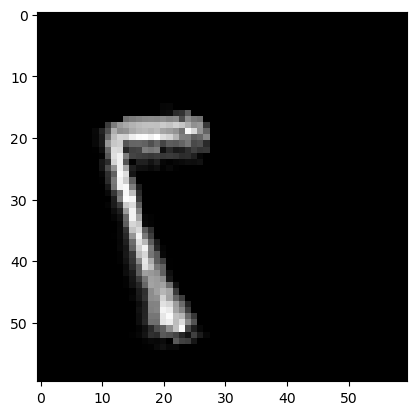

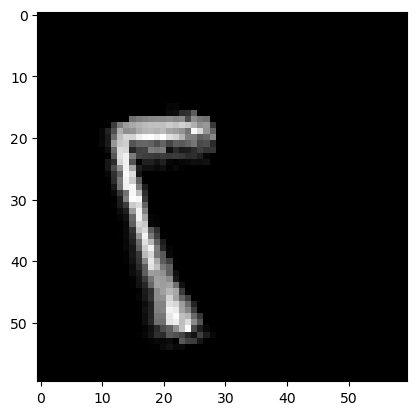

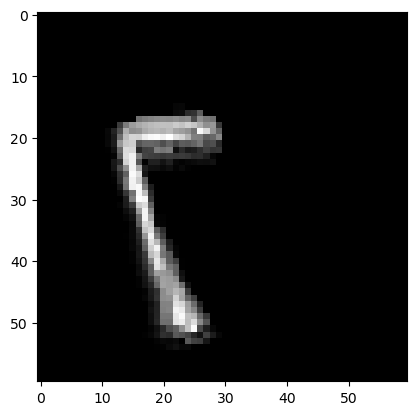

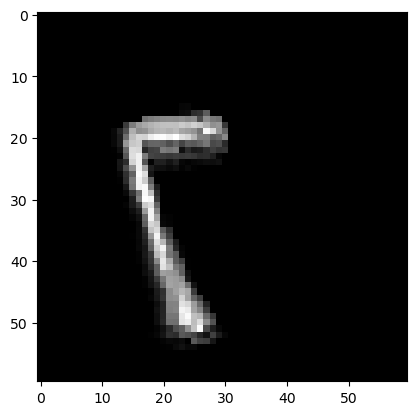

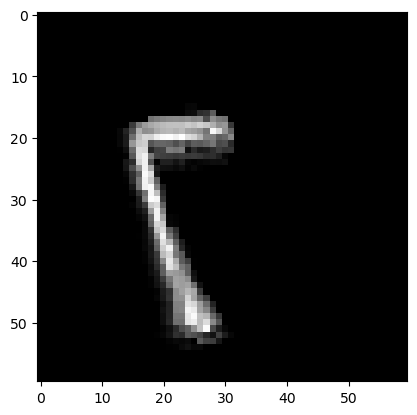

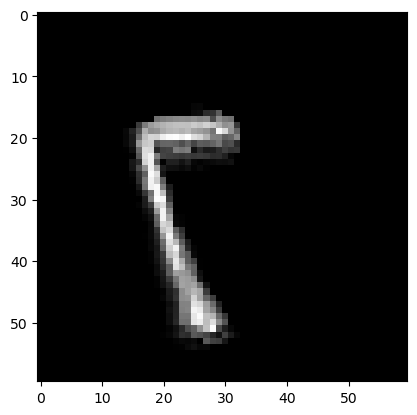

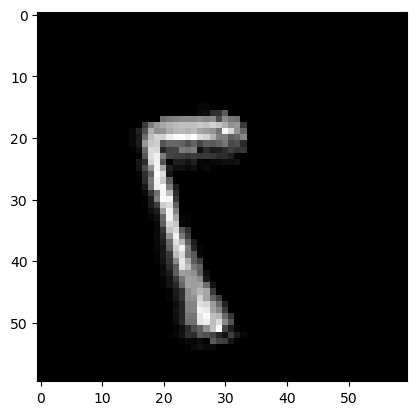

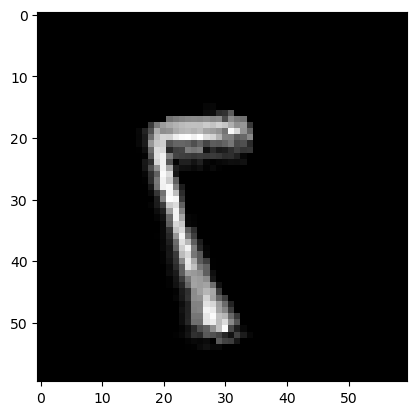

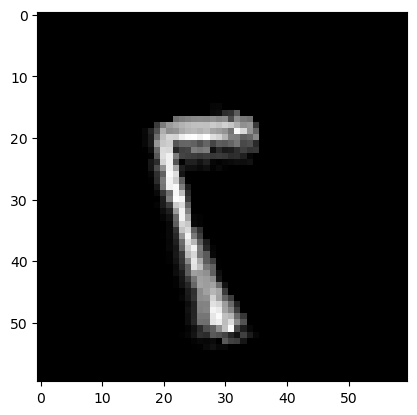

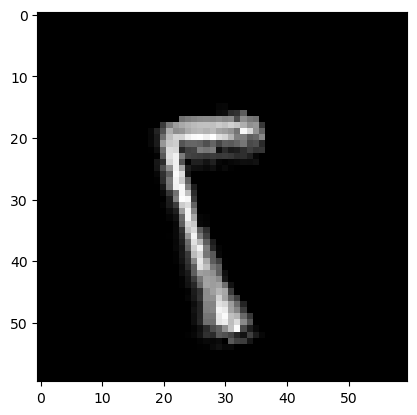

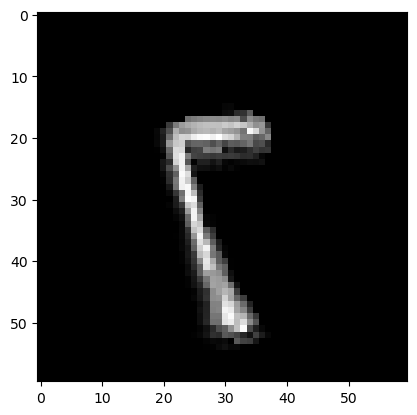

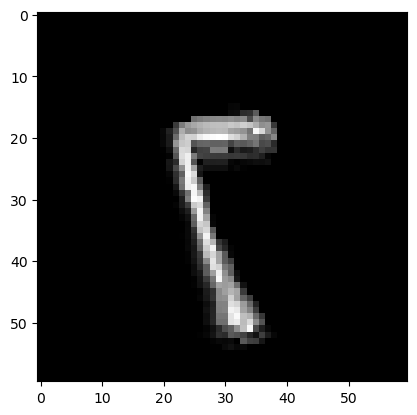

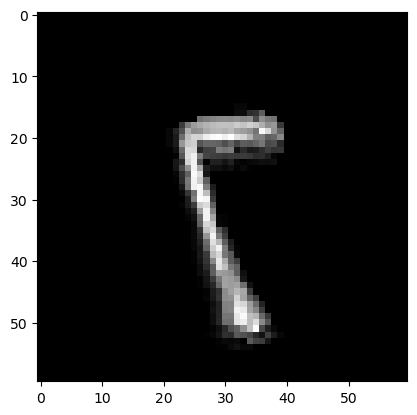

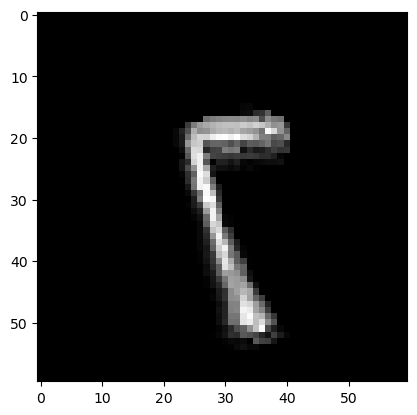

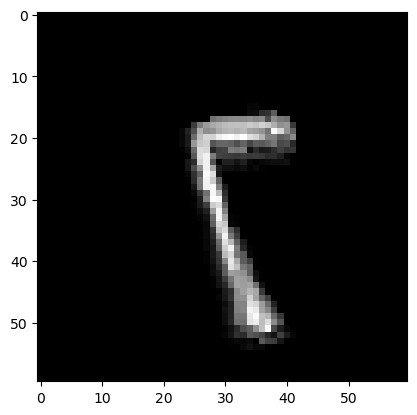

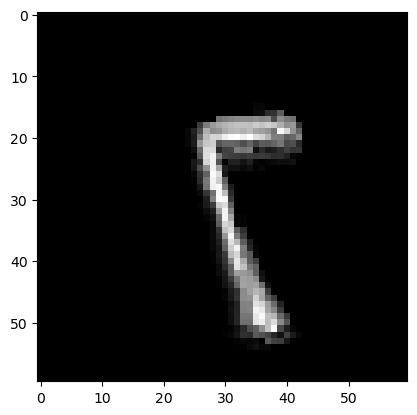

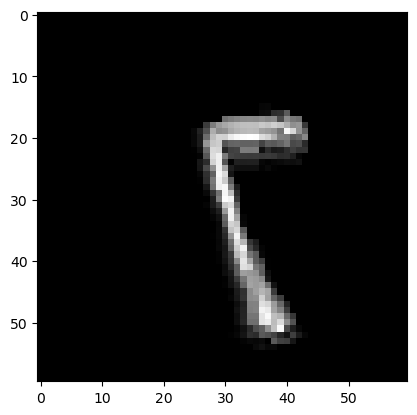

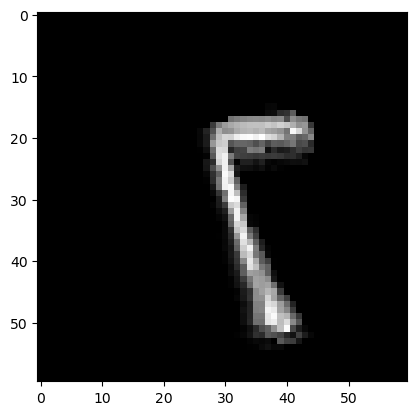

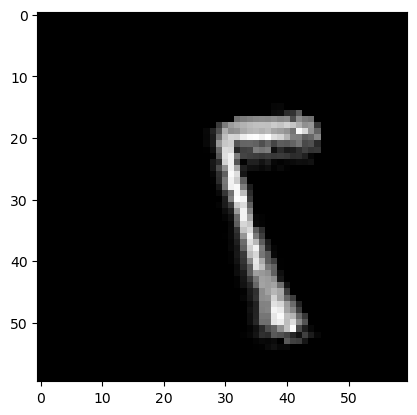

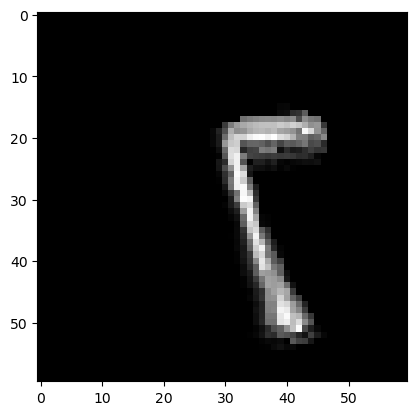

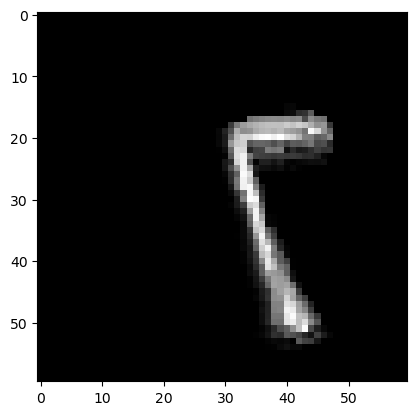

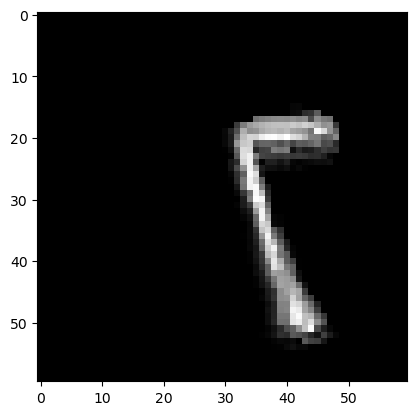

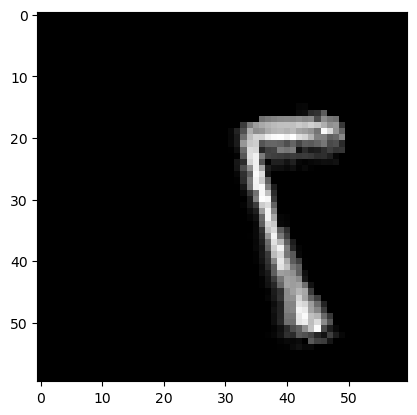

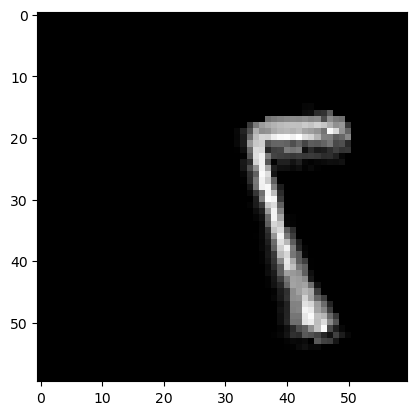

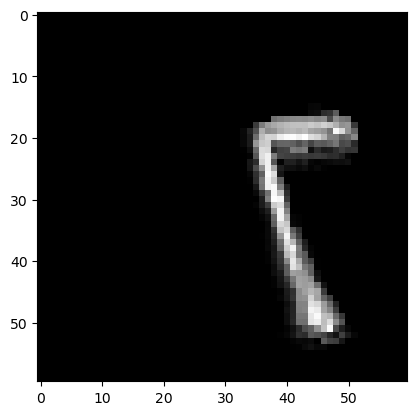

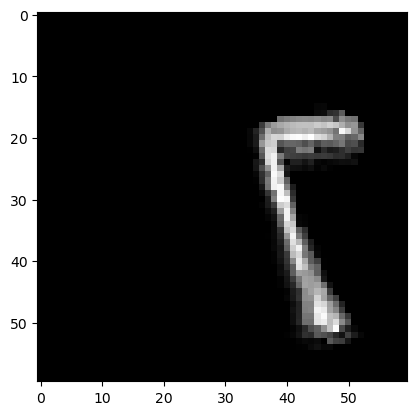

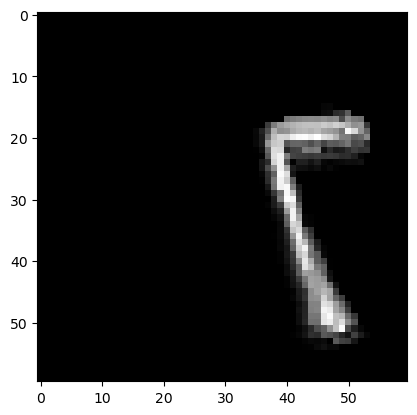

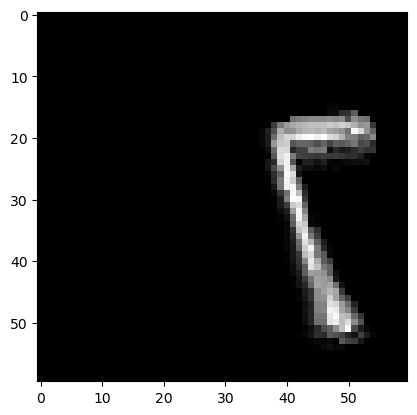

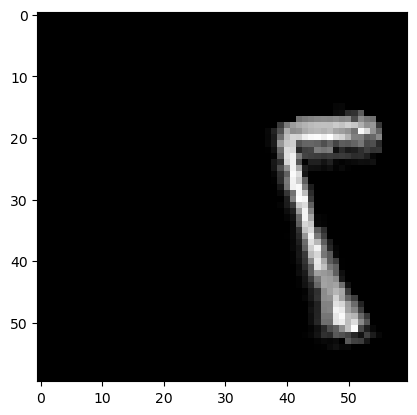

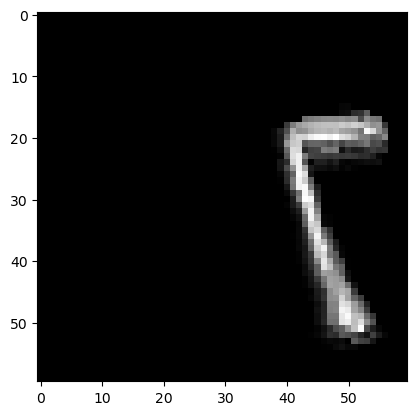

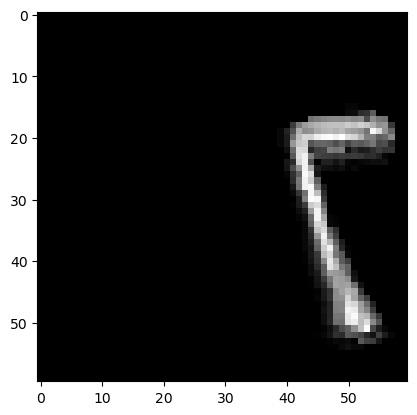

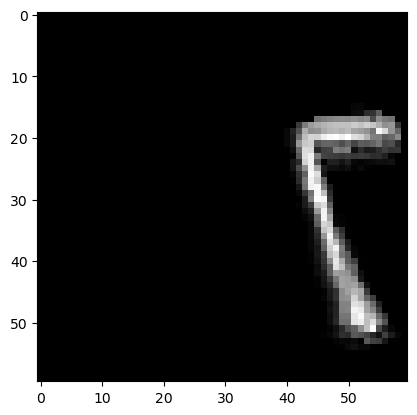

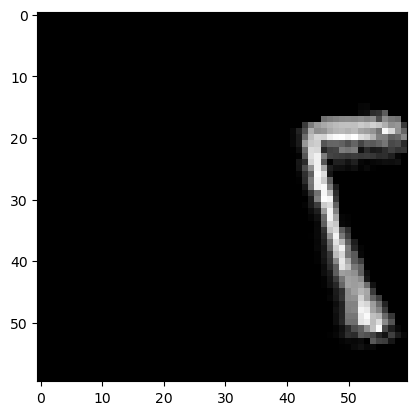

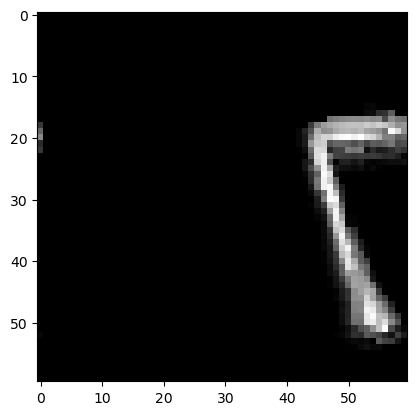

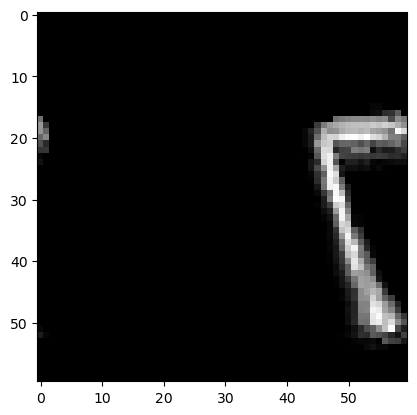

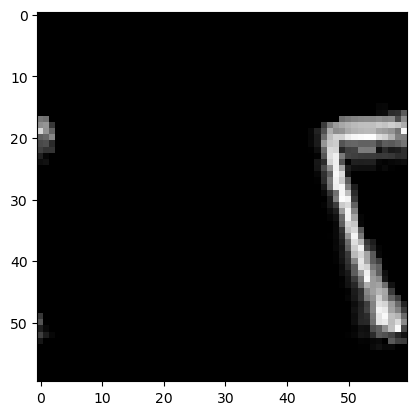

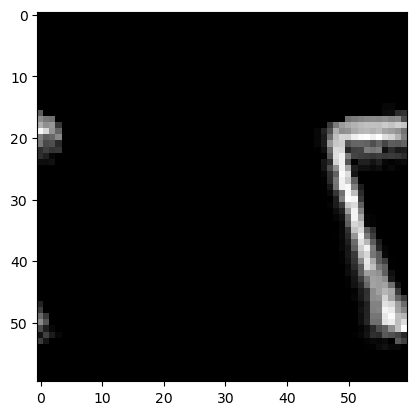

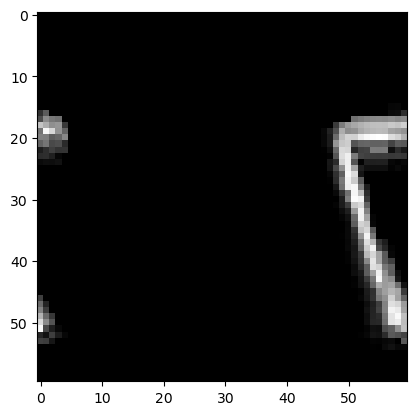

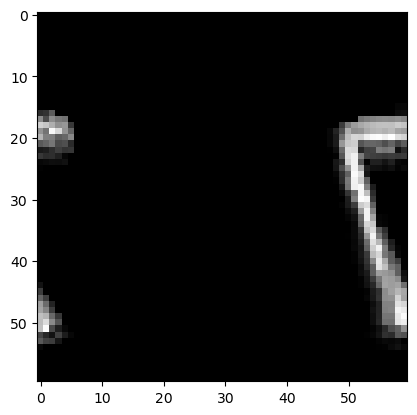

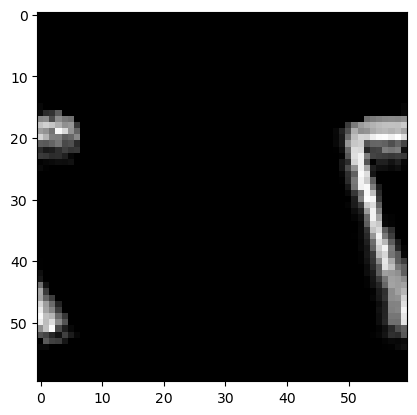

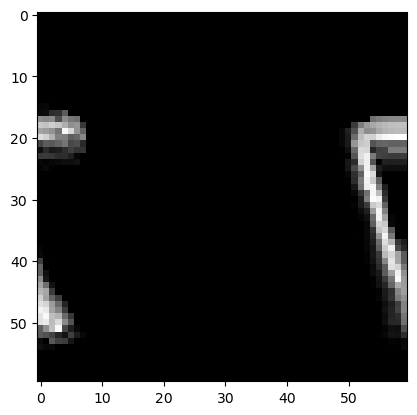

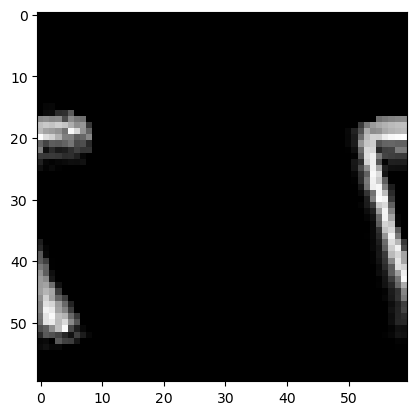

In [19]:
for i in range(60):
    plt.imshow(y[i,0], cmap='gray')
    plt.show()

In [20]:
l = model(y.cuda()).detach().cpu()

In [32]:
torch.max(l, dim=1)

torch.return_types.max(
values=tensor([17.4691, 17.3197, 17.4246, 17.8472, 17.5422, 16.4333, 16.0639, 16.2714,
        15.7099, 14.9732, 15.2475, 15.7562, 15.6297, 15.5857, 16.6225, 17.4691,
        17.3197, 17.3610, 17.8472, 17.5422, 16.4333, 16.0639, 16.2715, 15.7099,
        14.9732, 15.2475, 15.7562, 15.6297, 15.5857, 16.8964, 17.4691, 17.3197,
        17.4246, 17.8472, 17.6247, 16.4333, 16.0639, 16.2715, 15.7099, 14.9732,
        15.2475, 15.7562, 15.6297, 15.5857, 16.6225, 17.4691, 17.3197, 17.4246,
        17.8472, 17.5422, 16.4333, 16.0639, 16.2715, 16.3211, 14.9732, 15.7929,
        15.7562, 15.6297, 16.3393, 17.0915]),
indices=tensor([7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
        7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
        7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7]))

In [34]:
images = y
labels = test_data[0][1]

fmodel = PyTorchModel(model, bounds=(0, 255))

clean_pred = batched_predictions(model, images, bs)

print(clean_pred)

attack = Repeated(attack=LinfProjectedGradientDescentAttack(rel_stepsize=rel_stepsize, steps=steps, random_start=random_start), times=n_repeat)

_, advs, success = run_batched_attack_cpu(attack, fmodel, images, clean_pred, epsilons, bs)
advs = torch.stack(advs)


success_rate = ep.astensor(success).float32().mean(axis=-1).raw
adv_pred = batched_predictions_eps(model, advs, bs)
logits = batched_logits_eps(model, advs, bs)

print(success_rate)

  0%|          | 0/60 [00:00<?, ?it/s]

tensor([7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
        7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
        7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7])


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.8667, 0.9333, 1.0000, 1.0000])


In [38]:
print(adv_pred)

tensor([[7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
         7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
         7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7],
        [7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
         7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
         7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7],
        [7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
         7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
         7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7],
        [7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
         7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
         7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7],
        [7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
         7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
      

In [49]:
n_images = 60
x = {}
x['images'] = mnist_test['images'][0].reshape(1,28,28).astype(np.float64)
x['labels'] = mnist_test['labels'][0]

image = x['images']
projections = np.ndarray((n_images, 2 * bandwidth, 2 * bandwidth), dtype=np.uint8)
for i in range(n_images):
    grid = get_projection_grid(b=bandwidth)
    rot = rotation_matrix(theta=i/60, phi=0., z=0.)
    rotated_grid = rotate_grid(rot, grid)
    projections[i] = project_2d_on_sphere(image, rotated_grid)

z = torch.from_numpy(projections.astype(np.float32)).unsqueeze(1)

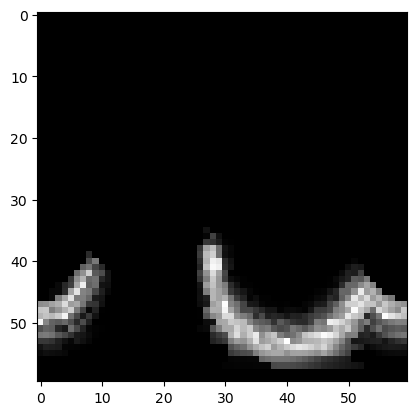

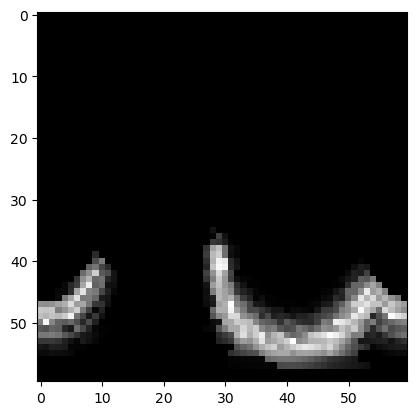

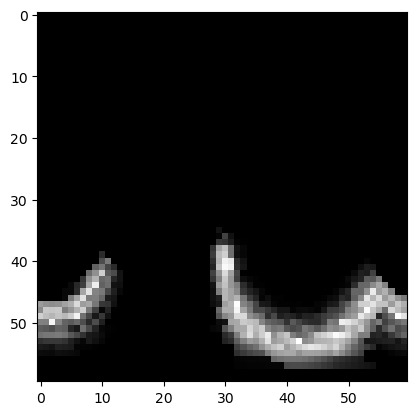

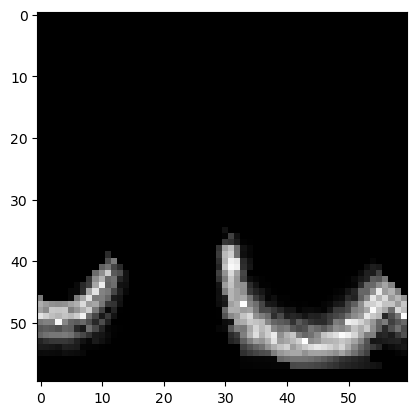

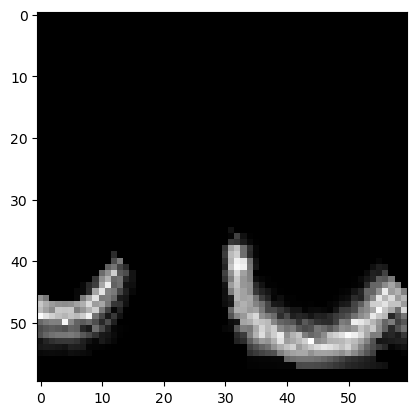

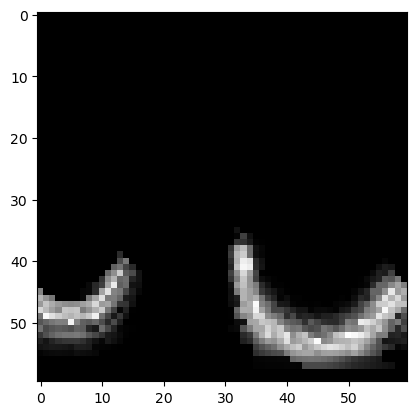

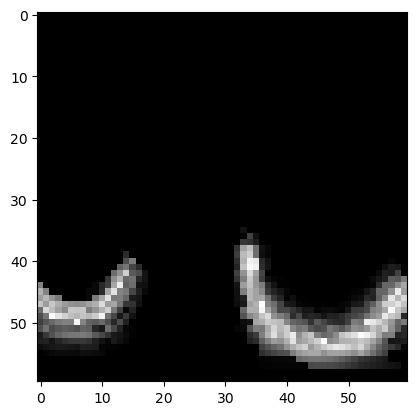

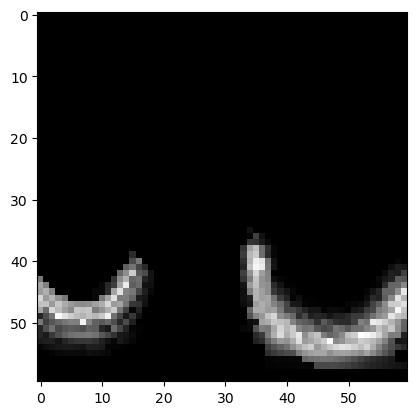

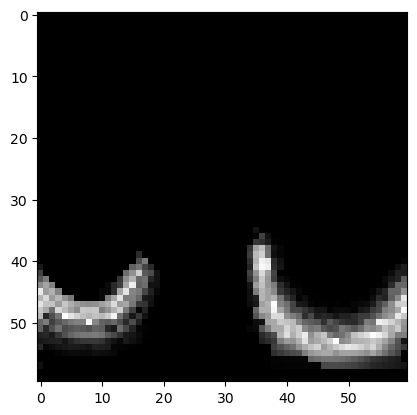

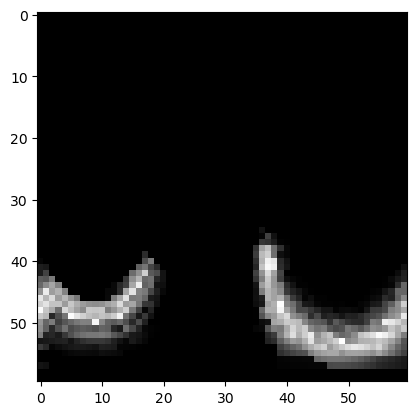

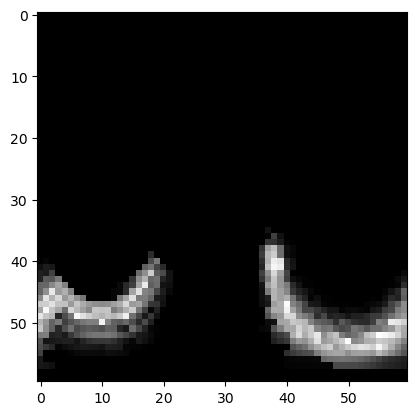

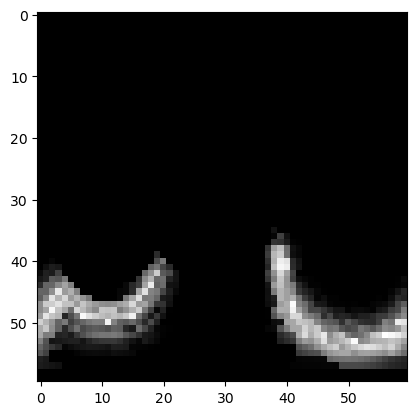

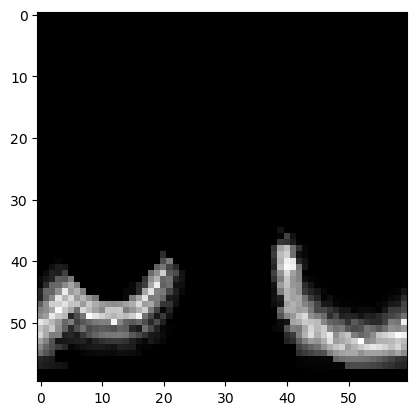

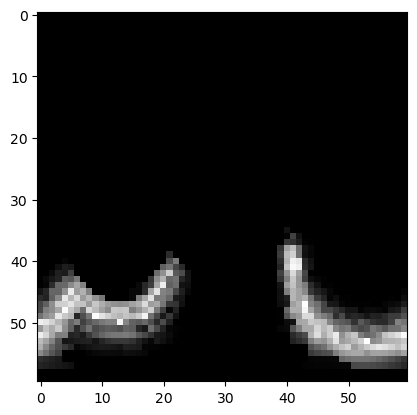

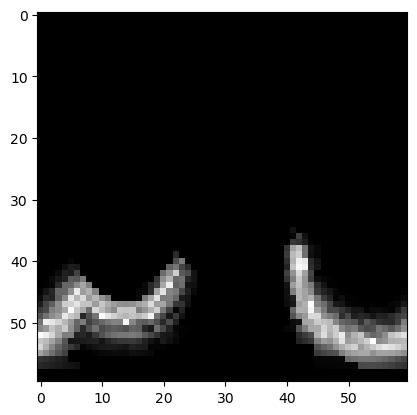

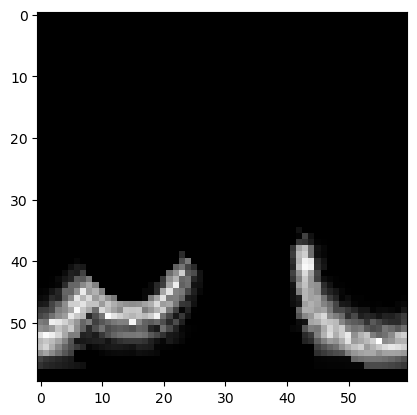

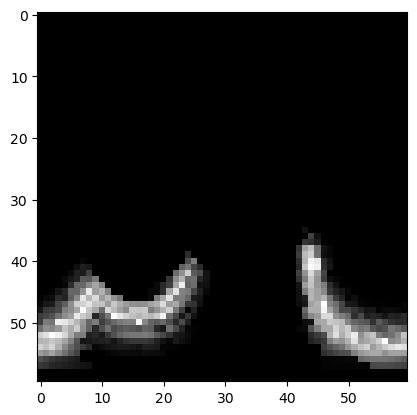

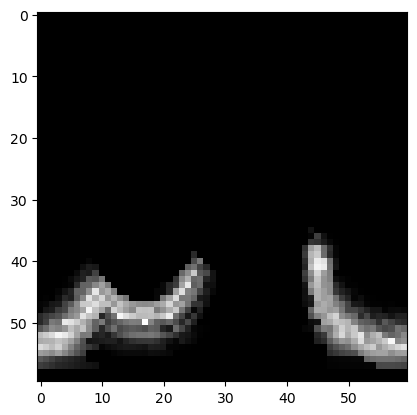

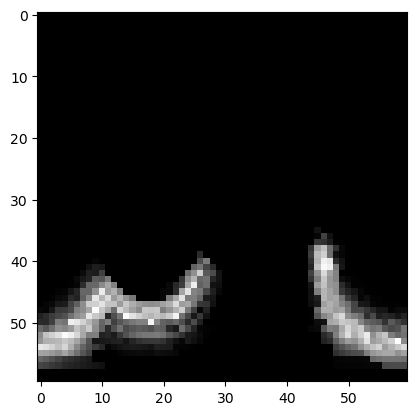

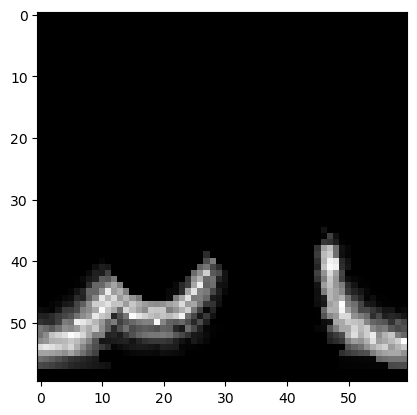

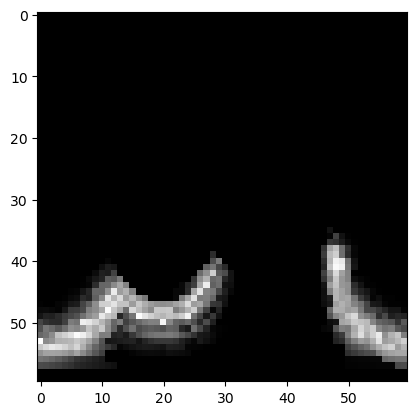

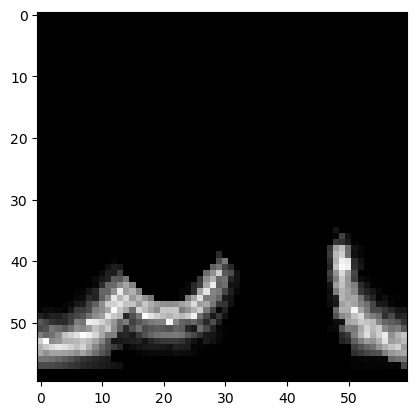

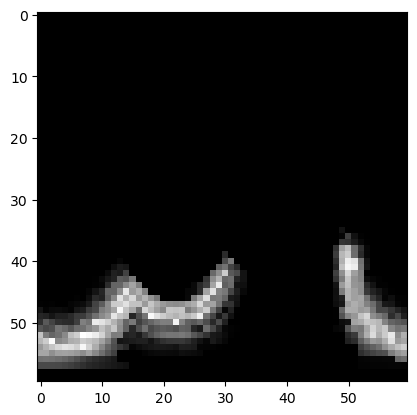

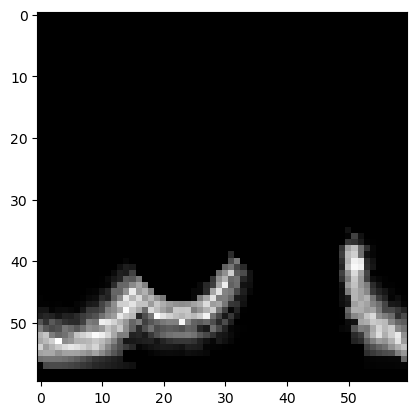

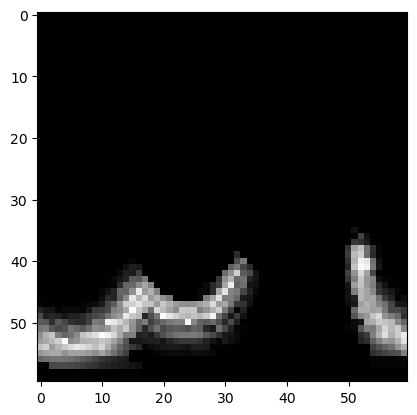

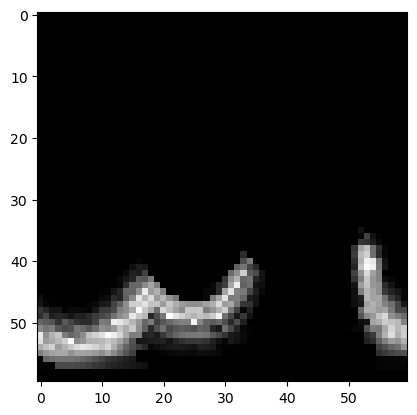

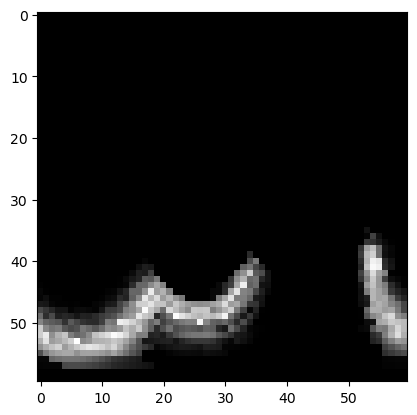

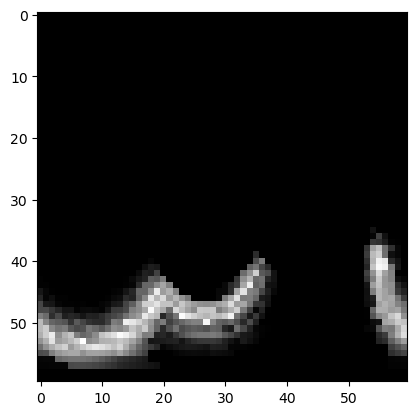

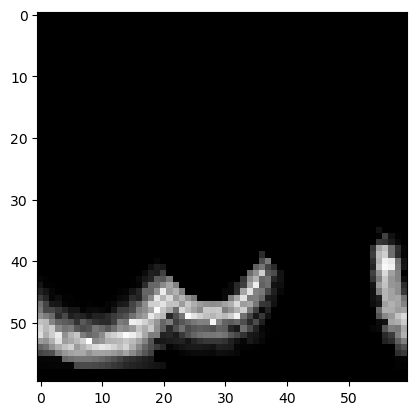

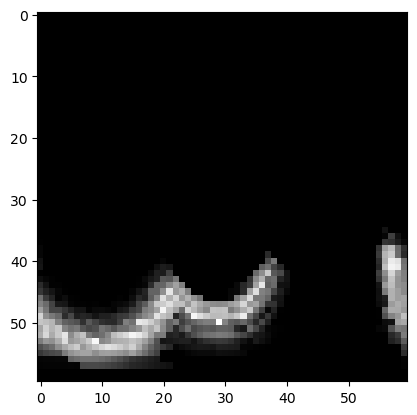

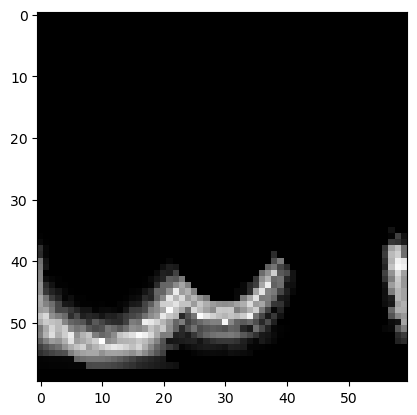

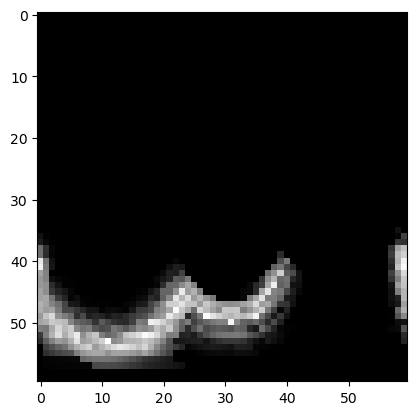

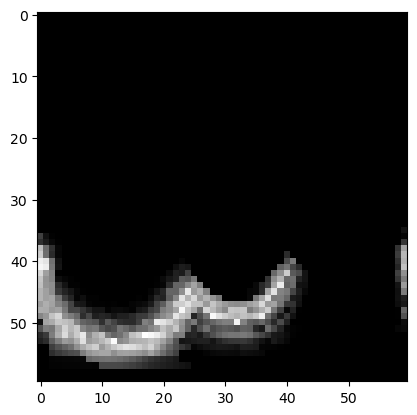

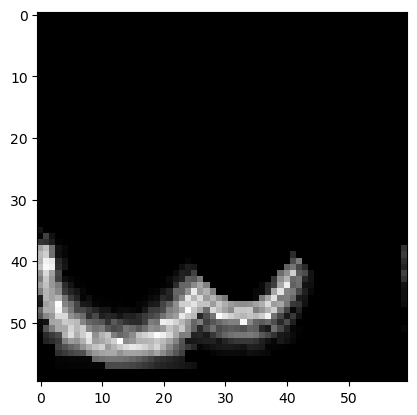

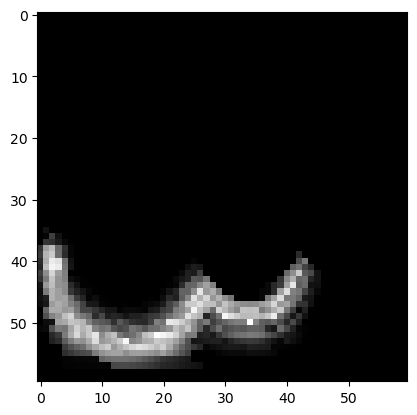

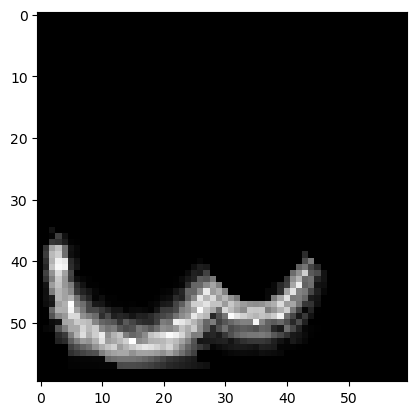

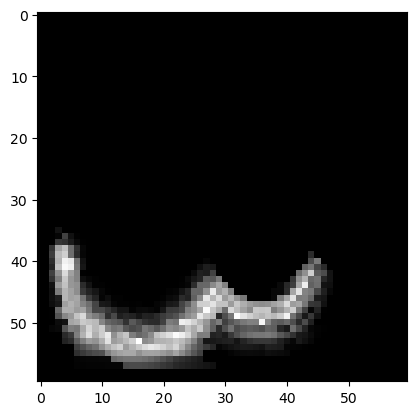

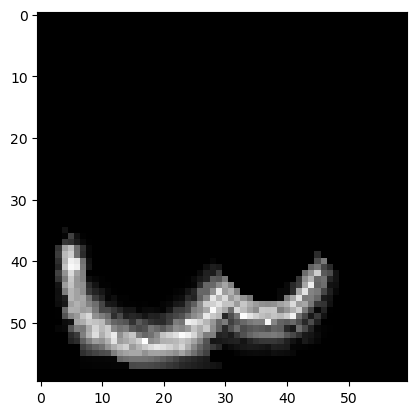

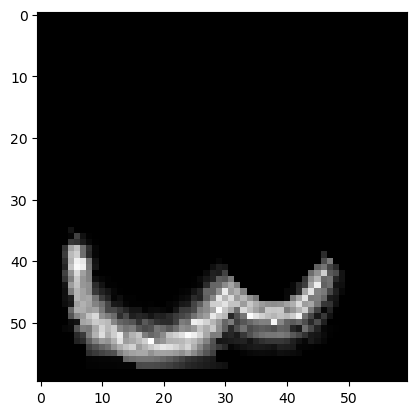

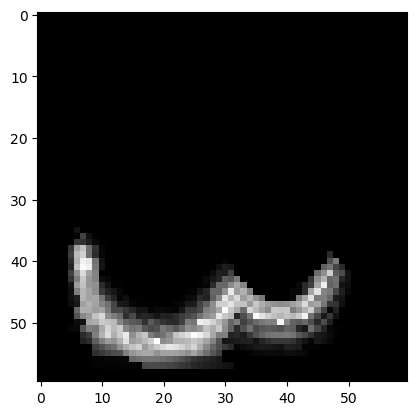

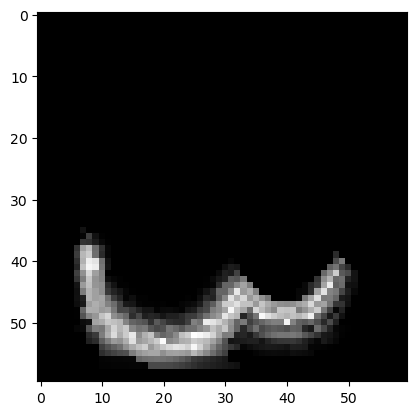

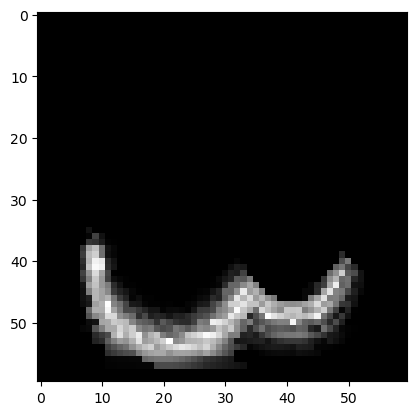

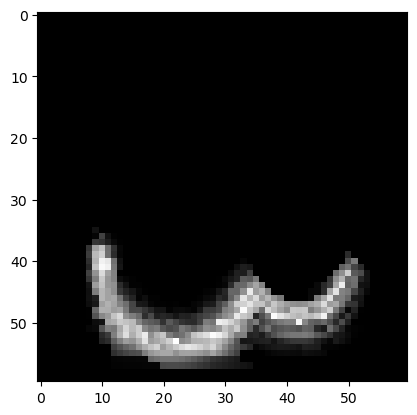

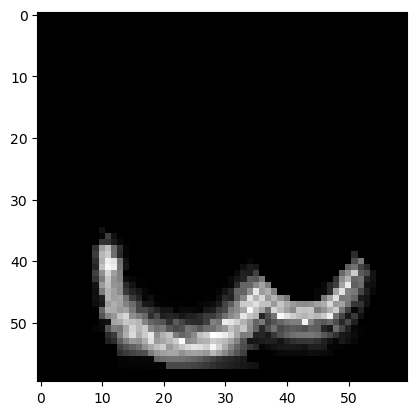

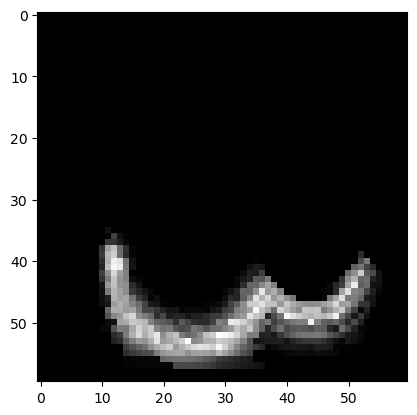

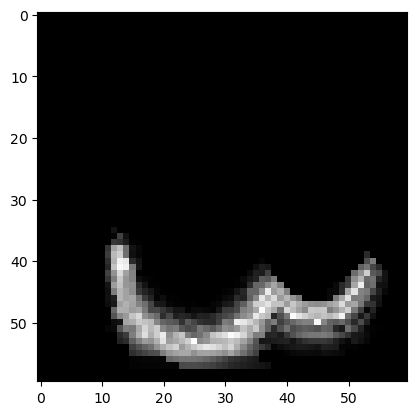

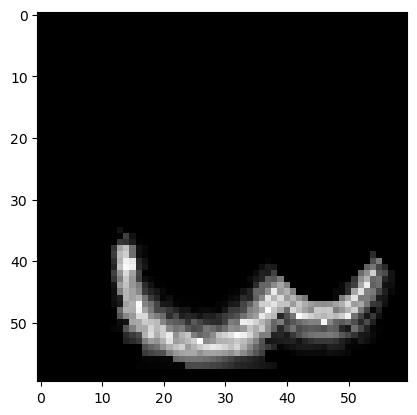

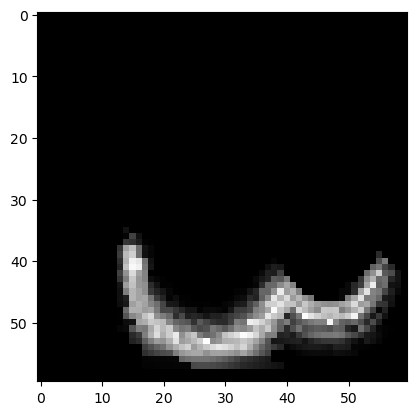

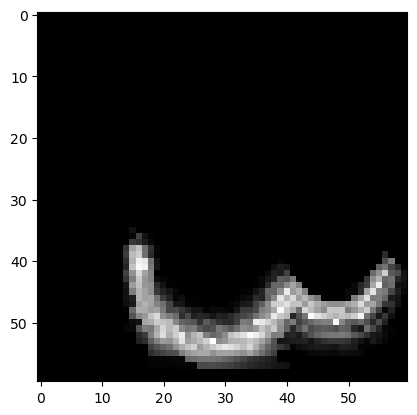

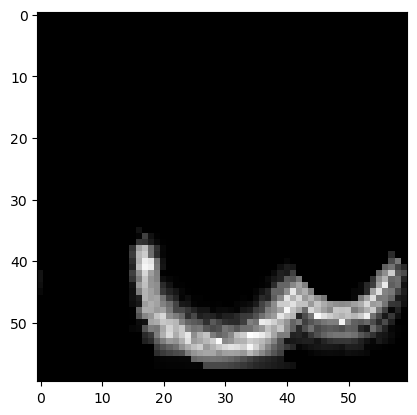

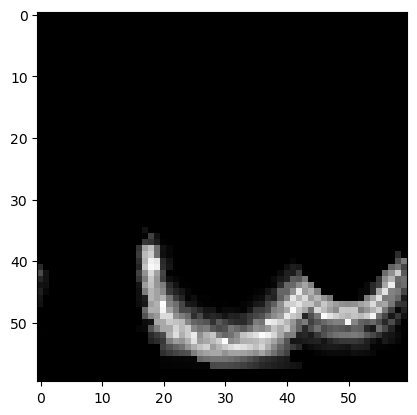

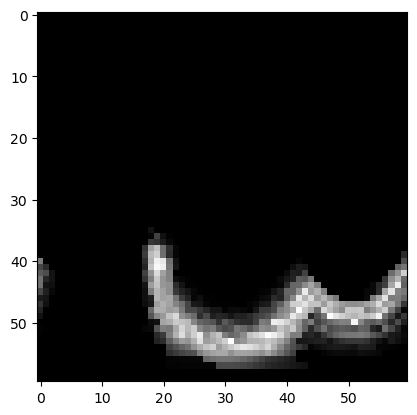

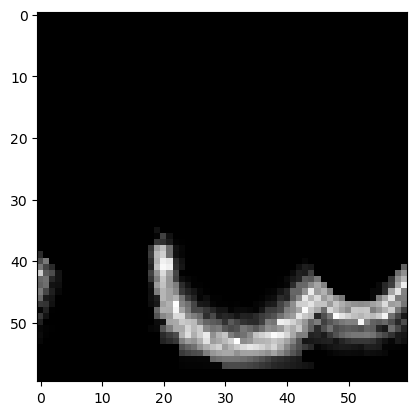

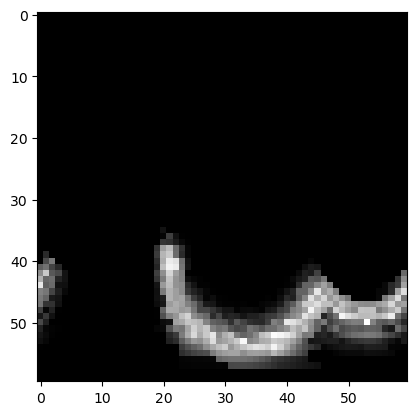

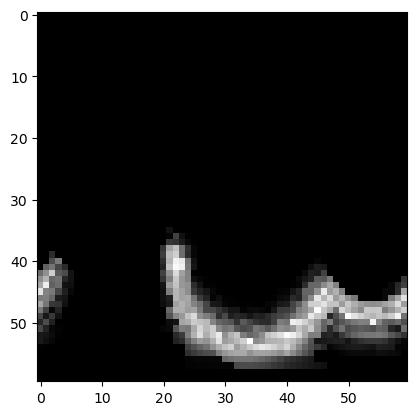

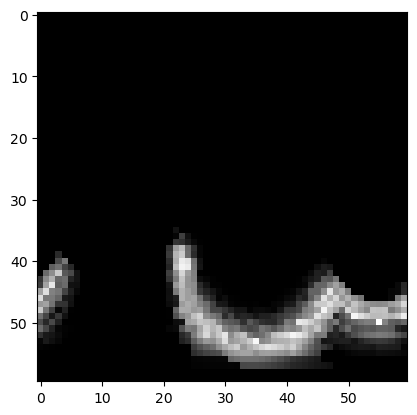

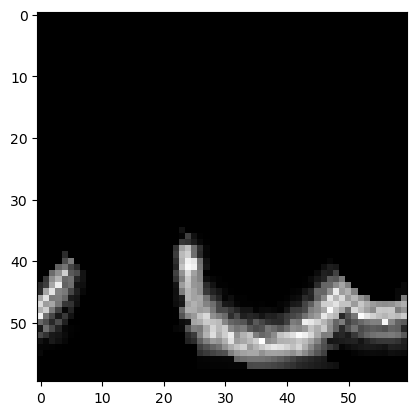

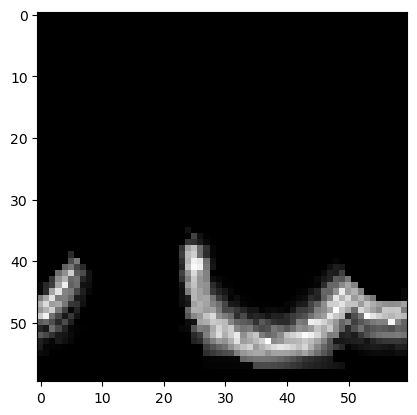

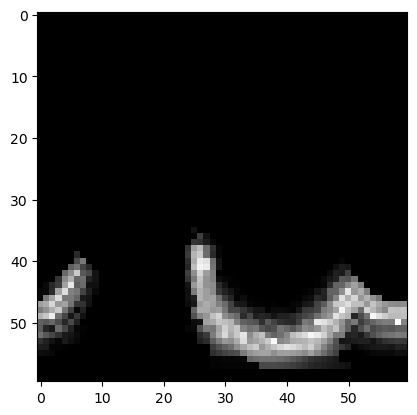

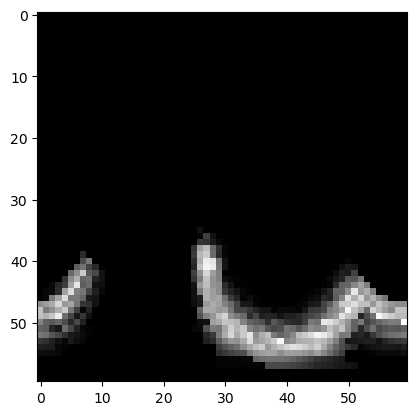

In [50]:
for i in range(60):
    plt.imshow(z[i,0], cmap='gray')
    plt.show()

In [51]:
images = z
labels = test_data[0][1]

fmodel = PyTorchModel(model, bounds=(0, 255))

clean_pred = batched_predictions(model, images, bs)

print(clean_pred)

attack = Repeated(attack=LinfProjectedGradientDescentAttack(rel_stepsize=rel_stepsize, steps=steps, random_start=random_start), times=n_repeat)

_, advs, success = run_batched_attack_cpu(attack, fmodel, images, clean_pred, epsilons, bs)
advs = torch.stack(advs)


success_rate = ep.astensor(success).float32().mean(axis=-1).raw
adv_pred = batched_predictions_eps(model, advs, bs)
logits = batched_logits_eps(model, advs, bs)

print(success_rate)

  0%|          | 0/60 [00:00<?, ?it/s]

tensor([7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
        7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
        7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7])


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.5833, 1.0000, 1.0000, 1.0000])


In [52]:
lz = model(z.cuda()).detach().cpu()
torch.max(lz, dim=1)

torch.return_types.max(
values=tensor([17.3460, 17.3744, 17.1196, 16.7483, 16.5961, 16.9569, 16.8797, 16.2731,
        17.3912, 17.4024, 16.7967, 17.0735, 17.1617, 17.5076, 17.1289, 17.2036,
        17.3529, 15.9994, 16.4888, 17.1202, 16.5065, 16.8652, 16.2824, 17.3881,
        16.9365, 16.5431, 17.2134, 17.1617, 16.8746, 16.0521, 16.8095, 16.7180,
        16.2009, 16.7982, 16.0573, 17.2207, 16.3368, 16.5859, 16.8643, 16.7669,
        16.2743, 17.3134, 17.0016, 16.6243, 16.3172, 16.9116, 17.4206, 16.4383,
        16.3222, 16.3342, 17.1347, 16.3368, 17.1046, 16.3379, 16.7669, 16.0288,
        16.8633, 17.0016, 16.4016, 16.0637]),
indices=tensor([7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
        7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
        7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7]))